# Creating a Data Pipeline for HappyPaws

HappyPaws creates fun and educational apps for pet owners. 

HappyPaws wants to help pet owners understand their pets better by tracking their activities and health through the app. 

The data engineering team is responsible for making sure all the pet data from thousands of users is organized and safe, so pet owners can get tips to keep their pets happy and healthy.



## Task

HappyPaws has collected three datasets over the past year: 
 - "pet_activities.csv" which logs daily activities of pets, 
 - "pet_health.csv" which records vet visits and health issues, and 
 - "users.csv" which contains information about the pet owners. 

Each dataset contains unique identifiers for pets and/or their owners. 

The engineers developing the app currently write code to cross reference all of these data sources. 

They want to make things easier by having a single table with all data included.

Your manager has asked you to write a Python function that cleans and merges these datasets into a single dataset. 

The final dataset should provide a comprehensive view of each pet's activities, health records, and owner information. 

- To test your code, your manager will run only the code `all_pet_data('pet_activities.csv', 'pet_health.csv', 'users.csv')`
- Your `all_pet_data()` function must return a DataFrame, with columns as described below.
- All columns must accurately match the descriptions provided below, including names.

## Data

The data that has been provided has the following structure

![image](../assets/image.png)

The function that you write must return data as described below. There should be a unique row for each activity/health visit. 

Where missing values are permitted, they should be in the default Python format.

|Column Name | Description |
|-------|-------|
| pet_id | Unique identifier for each pet. There should not be any missing values.|
| date | The date of the activity recorded or the date of the health visit, in date format. There should not be any missing values.|
| activity_type | The type of activity, one of 'Walking', 'Playing', 'Resting' or for rows that relate to a health visit, the value 'Health'. Missing values are permitted.|
| duration_minutes | The duration of the activity in minutes. For rows that relate to health visits, this should be 0. Missing values for other activities are permitted.|
| issue | The health issue identified or check-up note. For rows that relate to activities, this should be a missing value. Missing values for health activities are permitted.|
| resolution | The outcome or advice given for the issue. For rows that relate to activities, this should be a missing value. Missing values for health activities are permitted.|
| owner_id | Unique identifier for the pet owner. All pets must have an owner.|
| owner_age_group | The age group of the owner (e.g., 18-25, 26-35, etc.). Missing values are permitted.|
| pet_type | The type of pet (e.g., Dog, Cat). Missing values are permitted.|

## Code

### Imports

In [ ]:
# Imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utilities.processes import all_pet_data
from utilities.config import data, assets, code, products

### Data preparation

In [5]:
filelist = [data.activities, data.health, data.users]
cleaned = all_pet_data(*filelist, sort=True)
cleaned.to_csv(data / 'cleaned.csv', index=False)
display(cleaned.info())
display(cleaned.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1878 entries, 0 to 1877
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pet_id            1878 non-null   int64         
 1   date              1878 non-null   datetime64[ns]
 2   activity_type     1878 non-null   category      
 3   duration_minutes  1691 non-null   float64       
 4   issue             940 non-null    category      
 5   resolution        940 non-null    category      
 6   owner_id          1878 non-null   int64         
 7   owner_age_group   1878 non-null   object        
 8   pet_type          1878 non-null   category      
dtypes: category(4), datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 81.8+ KB


None

,pet_id,date,duration_minutes,owner_id
count,1878.000000,1878,1691.000000,1878.000000
mean,5159.256656,2023-02-13 17:15:54.632588032,20.086339,4915.624601
min,9.000000,2022-04-01 00:00:00,0.000000,12.000000
25%,2794.000000,2022-09-11 06:00:00,0.000000,2313.500000
50%,5288.000000,2023-02-08 00:00:00,0.000000,4945.000000
75%,7757.000000,2023-07-26 00:00:00,40.000000,7472.000000
max,9988.000000,2023-12-30 00:00:00,90.000000,9972.000000
std,2871.496497,NaN,28.300327,2959.977588


## Inspection and visualization

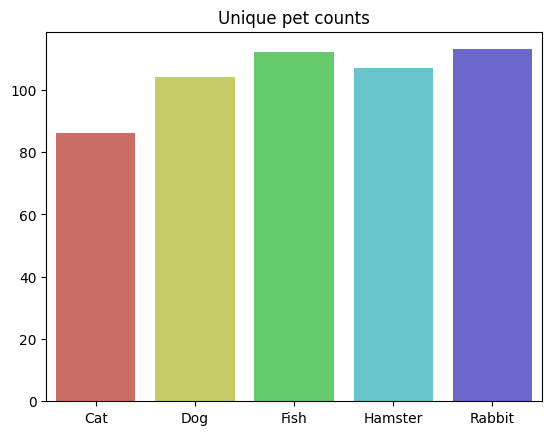

In [3]:
sns.set_palette('hls')
pet_counts = cleaned.groupby('pet_type', observed=True).pet_id.nunique().reset_index(name='counts')
ax = sns.barplot(pet_counts, x='pet_type', y='counts', hue='pet_type')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Unique pet counts')
plt.show()

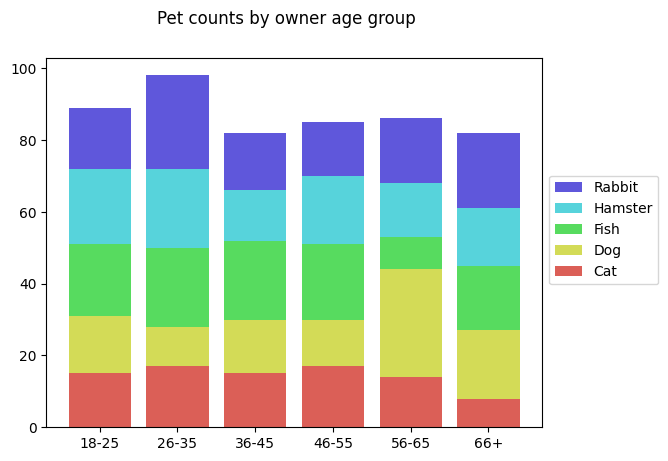

In [4]:
unique = cleaned.drop_duplicates(subset=['pet_id', 'owner_id'])[['owner_age_group', 'pet_type']]
unique_counts = unique.groupby('owner_age_group').pet_type.value_counts().reset_index(name='counts').sort_values(['pet_type', 'owner_age_group']).set_index(['pet_type', 'owner_age_group'])
# age_counts = cleaned.groupby(['owner_age_group', 'pet_type'], observed=True).pet_id.nunique()
# age_counts = age_counts.reset_index(name='counts').set_index('pet_type')
pet_types = list(unique_counts.index.get_level_values(0).unique())
age_groups = list(unique_counts.index.get_level_values(1).unique())
totals = np.array([0 for x in range(len(age_groups))])
for i, pet in enumerate(pet_types):
    new = unique_counts.loc[pet].counts.values
    plt.bar(age_groups, new, label=pet, color=sns.color_palette()[i], bottom=totals)
    totals += new
plt.legend(loc='best', bbox_to_anchor=(1, 0.7), reverse=True)
plt.suptitle('Pet counts by owner age group')
plt.show()

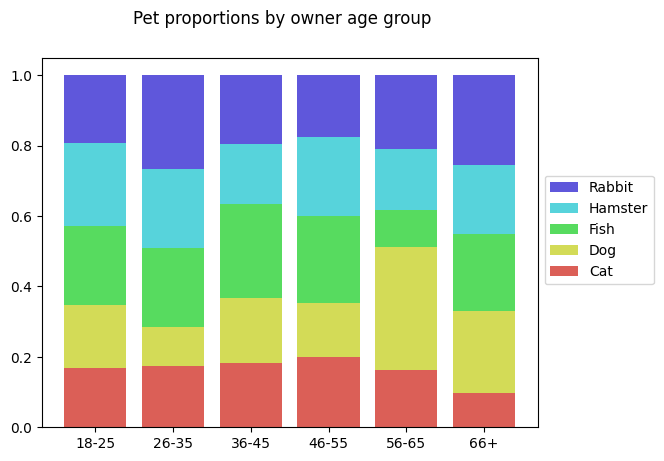

In [5]:
unique = cleaned.drop_duplicates(subset=['pet_id', 'owner_id'])[['owner_age_group', 'pet_type']]
unique_prop = unique.groupby('owner_age_group', observed=True).pet_type.value_counts(normalize=True).reset_index(name='prop').sort_values(['pet_type', 'owner_age_group',]).set_index(['pet_type', 'owner_age_group'], drop=True)
totals = np.array([0.0 for x in range(len(age_groups))])
for i, pet in enumerate(pet_types):
    new = unique_prop.loc[pet].prop.values
    plt.bar(age_groups, new, label=pet, color=sns.color_palette()[i], bottom=totals)
    totals += new
plt.legend(loc='best', bbox_to_anchor=(1, 0.7), reverse=True)
plt.suptitle('Pet proportions by owner age group')
plt.show()

In [6]:
# Average number of health activities per month by animal

In [7]:
# Distribution of non-health activities by month (max, min, average)